In [2]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors

# Test Description:
Here we want to compare original input data (raw dataset from Huang et al, 2018) with the one which will be seen by the model prepared with CLM tools.

We will look into global values and plot the corresponding timeseries. 

By doing this for every used variable, and each year, we make sure that we indeed use the right data, and no mistake was introduced in the process of preparing the model input data.

The original data is avaialable at 0.5x0.5 deg resolution at /glade/work/staranu/mksrf_data_for_each_year/. 

Transformed data is avaialable at 0.9x1.25 deg resolution (f09_g17) at /glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/sector_water_inputs.txt.

Land area of model grid at 0.9x1.25 deg is: 166.95 million km2
Land area of original data at 0.5x0.5 deg is: 132.31 million km2
The difference in the area is caused mostly by missing Antarctica in the 720_360 mask file, which will not affect our analysis. See map bellow, with red color representing the f09_g17 land mask and blue color the 720x360 land mask: 


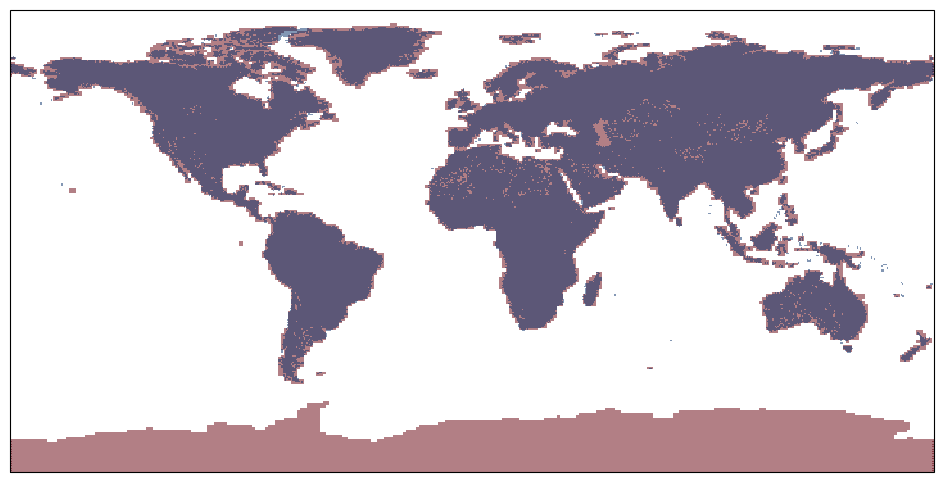

In [3]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lnd_area_720_360_grid = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/area_rof.nc', decode_times=False)['area'].values.flatten() # 720x360 grid area
mask_720_360_grid = xr.open_dataset('/glade/u/home/staranu/useful_data/rof_mask.nc', decode_times=False)['mask'].values.flatten()
lnd_area_720_360_grid = np.where((mask_720_360_grid == 1) | (mask_720_360_grid == 3), lnd_area_720_360_grid, np.nan)
grid_720_360_mm_per_year_to_km3_per_year_transform = mm_to_m*lnd_area_720_360_grid/(10**9)


lon_720_360_grid  =  xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_1971.nc')['lon'].values
lat_720_360_grid  =  xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_1971.nc')['lat'].values

lon_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

print("Land area of model grid at 0.9x1.25 deg is: "  + str(np.round(np.nansum(lnd_area_ctsm_f09_g17)/10**12,2)) + " million km2")
print("Land area of original data at 0.5x0.5 deg is: "  + str(np.round(np.nansum(lnd_area_720_360_grid)/10**12,2)) + " million km2")
print("The difference in the area is caused mostly by missing Antarctica in the 720_360 mask file, which will not affect our analysis. See map bellow, with red color representing the f09_g17 land mask and blue color the 720x360 land mask: ")

mask_720_360_grid = np.where(mask_720_360_grid == 2, mask_720_360_grid, 1)
mask_720_360_grid = np.where(mask_720_360_grid == 1, mask_720_360_grid, np.nan)

# Plotting the masks
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('Reds')
ax.pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, mask_lnd_ctsm_f09_g17.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=1, alpha=0.5)
cmap = plt.get_cmap('Blues')
ax.pcolormesh(lon_720_360_grid, lat_720_360_grid, mask_720_360_grid.reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0])), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=1, alpha =0.5)

plt.show()

In [4]:
dom_withd_720_360_grid  = (xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_2010.nc', decode_times=False)['withd_dom']).sum(dim='time')
dom_withd_ctsm_f09_g17 = (xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/2010/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2010_c230217.nc', decode_times=False)['withd_dom']).sum(dim='time')

liv_withd_720_360_grid  = (xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_2010.nc', decode_times=False)['withd_liv']).sum(dim='time')
liv_withd_ctsm_f09_g17 = (xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/2010/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2010_c230217.nc', decode_times=False)['withd_liv']).sum(dim='time')

elec_withd_720_360_grid  = (xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_2010.nc', decode_times=False)['withd_elec']).sum(dim='time')
elec_withd_ctsm_f09_g17 = (xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/2010/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2010_c230217.nc', decode_times=False)['withd_elec']).sum(dim='time')

mfc_withd_720_360_grid  = (xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_2010.nc', decode_times=False)['withd_mfg']).sum(dim='time')
mfc_withd_ctsm_f09_g17 = (xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/2010/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2010_c230217.nc', decode_times=False)['withd_mfc']).sum(dim='time')

min_withd_720_360_grid  = (xr.open_dataset('/glade/work/staranu/mksrf_data_for_each_year/mksrf_sectorWater_0.5x0.5_simyr_2010.nc', decode_times=False)['withd_min']).sum(dim='time')
min_withd_ctsm_f09_g17 = (xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/2010/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr2010_c230217.nc', decode_times=False)['withd_min']).sum(dim='time')



dom_withd_720_360_grid.values  = (dom_withd_720_360_grid.values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform).reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0]))
dom_withd_ctsm_f09_g17.values = (dom_withd_ctsm_f09_g17.values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

liv_withd_720_360_grid.values  = (liv_withd_720_360_grid.values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform).reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0]))
liv_withd_ctsm_f09_g17.values = (liv_withd_ctsm_f09_g17.values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

elec_withd_720_360_grid.values  = (elec_withd_720_360_grid.values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform).reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0]))
elec_withd_ctsm_f09_g17.values = (elec_withd_ctsm_f09_g17.values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

mfc_withd_720_360_grid.values  = (mfc_withd_720_360_grid.values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform).reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0]))
mfc_withd_ctsm_f09_g17.values = (mfc_withd_ctsm_f09_g17.values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

min_withd_720_360_grid.values  = (min_withd_720_360_grid.values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform).reshape((lat_720_360_grid.shape[0], lon_720_360_grid.shape[0]))
min_withd_ctsm_f09_g17.values = (min_withd_ctsm_f09_g17.values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

print("Over the 40 years of the simulations, the cummulated difference between simulated and input data values are: ")
print("Domestic Withdrawal : " + str(np.round((np.nansum(dom_withd_720_360_grid)-np.nansum(dom_withd_ctsm_f09_g17))/np.nansum(dom_withd_720_360_grid)*100, 2)) + "%")
print("Livestock Withdrawal : " + str(np.round((np.nansum(liv_withd_720_360_grid)-np.nansum(liv_withd_ctsm_f09_g17))/np.nansum(liv_withd_720_360_grid)*100, 2)) + "%")
print("Electric Withdrawal : " + str(np.round((np.nansum(elec_withd_720_360_grid)-np.nansum(elec_withd_ctsm_f09_g17))/np.nansum(elec_withd_720_360_grid)*100, 2)) + "%")
print("Manufacturing Withdrawal : " + str(np.round((np.nansum(mfc_withd_720_360_grid)-np.nansum(mfc_withd_ctsm_f09_g17))/np.nansum(mfc_withd_720_360_grid)*100, 2)) + "%")
print("Mining Withdrawal : " + str(np.round((np.nansum(min_withd_720_360_grid)-np.nansum(min_withd_ctsm_f09_g17))/np.nansum(min_withd_720_360_grid),2)) + "%")

Over the 40 years of the simulations, the cummulated difference between simulated and input data values are: 
Domestic Withdrawal : -2.05%
Livestock Withdrawal : 1.11%
Electric Withdrawal : -0.29%
Manufacturing Withdrawal : 1.58%
Mining Withdrawal : 0.01%


In [5]:
# Make preparations for the analysis part

# create a 2D array of zeros with dimensions 10x40 where 10 is the number of sectors (for each sector 2 fluxes) and 40 total number of years between 1971-2010
# indices for each sector: 0 (domestic withdrawal), 1 (livestock withdrawal), 2 (thermoelectric withdrawal), 3 (manufacturing withdrawal), 4 (mining withdrawal), 5 (domestic consumption), 6 (livestock consumption), 7 (thermoelectric consumption), 8 (manufacturing consumption), 9 (mining consumption)
original_data  = np.zeros((10, 40))
ctsmTools_data = np.zeros((10, 40))

# set the directory path for the original and CTSM tools based input data
original_directory_path  = "/glade/work/staranu/mksrf_data_for_each_year/"
ctsmTools_directory_path = "/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/"

# get a list of each year input data in the corresponding directories
original_list  = glob.glob(original_directory_path + "mksrf_sectorWater_0.5x0.5_simyr_*")
original_list.sort()
ctsmTools_list = []
for year in range(1971,2011):
    ctsmTools_list.append( glob.glob(ctsmTools_directory_path + str(year) + "/*.nc")[0])
    

sector_fluxes_names_orig      = ["withd_dom", "withd_liv", "withd_elec", "withd_mfg", "withd_min", "cons_dom", "cons_liv", "cons_elec", "cons_mfg", "cons_min"]
sector_fluxes_names_ctsmTools = ["withd_dom", "withd_liv", "withd_elec", "withd_mfc", "withd_min", "cons_dom", "cons_liv", "cons_elec", "cons_mfc", "cons_min"]

for year in range(1971,2011):
    for sector in range(0, 10):
        original_data[sector, year-1971]  = np.nansum((xr.open_dataset(original_list[year-1971], decode_times=False)[sector_fluxes_names_orig[sector]]).sum(dim='time').values.flatten()*grid_720_360_mm_per_year_to_km3_per_year_transform)
        ctsmTools_data[sector, year-1971] = np.nansum((xr.open_dataset(ctsmTools_list[year-1971], decode_times=False)[sector_fluxes_names_ctsmTools[sector]]).sum(dim='time').values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform)
    print("Year completed: " + str(year))

Year completed: 1971
Year completed: 1972
Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


# Vizualize annual correspondence between original data and the one obtained through CTSM tools
Each point represent the global mean value for the given year.

In general, good aggrement observed between the original data and the one created through CTSM tools.

The average relative error is below 3% tipically. The only exception is for the thermoelectric consumption volume, the main reason being that for this sectors, the values are really low (most water is recycled).  

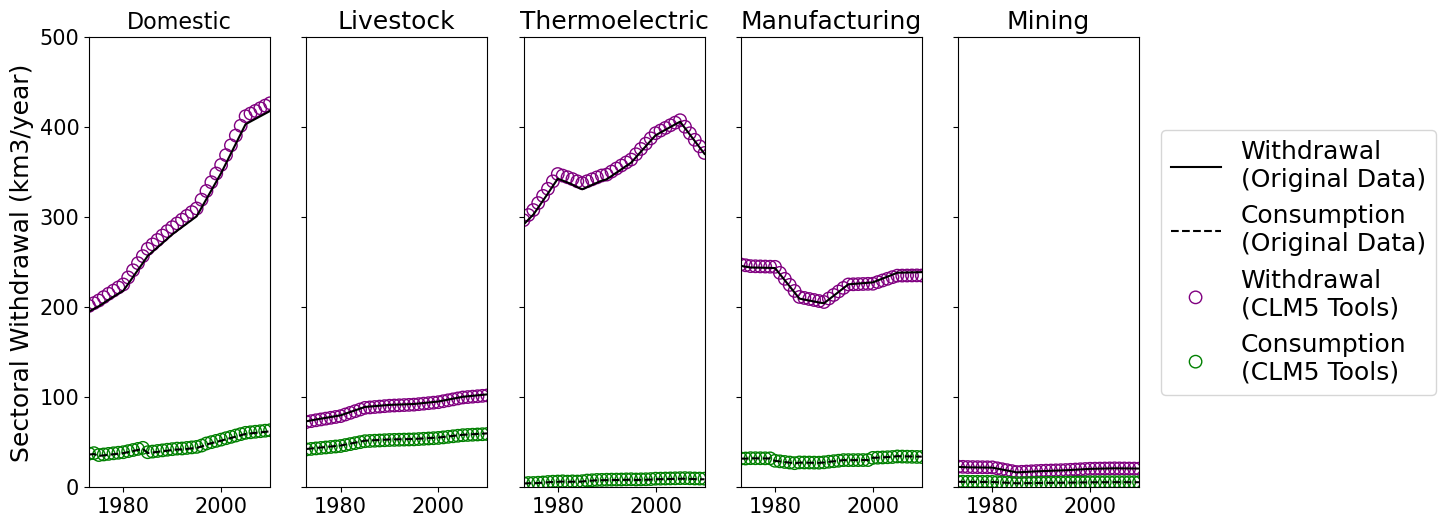

In [6]:
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=5)

years = np.arange(1973, 2011)
axis_list = axes.flatten()
axis_list[0].set_xlim([1973, 2010])
axis_list[0].set_ylim([0, 500])
axis_list[0].plot(years, original_data[0, 2:], label="Withdrawal\n(Original Data)", color="k")
axis_list[0].plot(years, original_data[5, 2:], label="Consumption\n(Original Data)", color="k", ls="--")
axis_list[0].scatter(years, ctsmTools_data[0, 2:], label="Withdrawal\n(CLM5 Tools)", s=80, facecolors='none', edgecolors='purple')
axis_list[0].scatter(years, ctsmTools_data[5, 2:], label="Consumption\n(CLM5 Tools)", s=80, facecolors='none', edgecolors='green')
axis_list[0].set_title("Domestic", fontsize=16)
# axis_list[0].set_xlabel("Year", fontsize=18)
axis_list[0].set_ylabel("Sectoral Withdrawal (km3/year)", fontsize=18)
axis_list[0].tick_params(labelsize=15)
axis_list[0].legend(fontsize=18, loc='center left', bbox_to_anchor=(5.85, 0.5))

for i in range(1, 5):
    axis_list[i].set_xlim([1973, 2010])
    axis_list[i].set_ylim([0, 500])
    axis_list[i].plot(years, original_data[i, 2:], color="k")
    axis_list[i].scatter(years, ctsmTools_data[i, 2:], s=80, facecolors='none', edgecolors='purple')
    axis_list[i].plot(years, original_data[i+5, 2:], color="k", ls="--")
    axis_list[i].scatter(years, ctsmTools_data[i+5, 2:], s=80, facecolors='none', edgecolors='green')
    axis_list[i].set_title(["Livestock", "Thermoelectric", "Manufacturing", "Mining"][i-1], fontsize=18)
    # axis_list[i].set_xlabel("Year", fontsize=18)
    axis_list[i].tick_params(labelsize=15)
    axis_list[i].set_yticklabels([])  # This will hide the y-axis values for subplots other than the first one.

# Create some extra space around the figure
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.75)

# Save the figure
plt.savefig("Results/png_format/Remapping_robustness_annual.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [7]:
# Compute mean relative error for each sector, as well as both withdrawal and consumption fluxes:
relative_error = np.zeros((10, 40))
for year in range(0,40):
    for sector in range(0,10):
        relative_error[sector, year] = (np.abs(original_data[sector, year]-ctsmTools_data[sector, year])/original_data[sector, year])*100


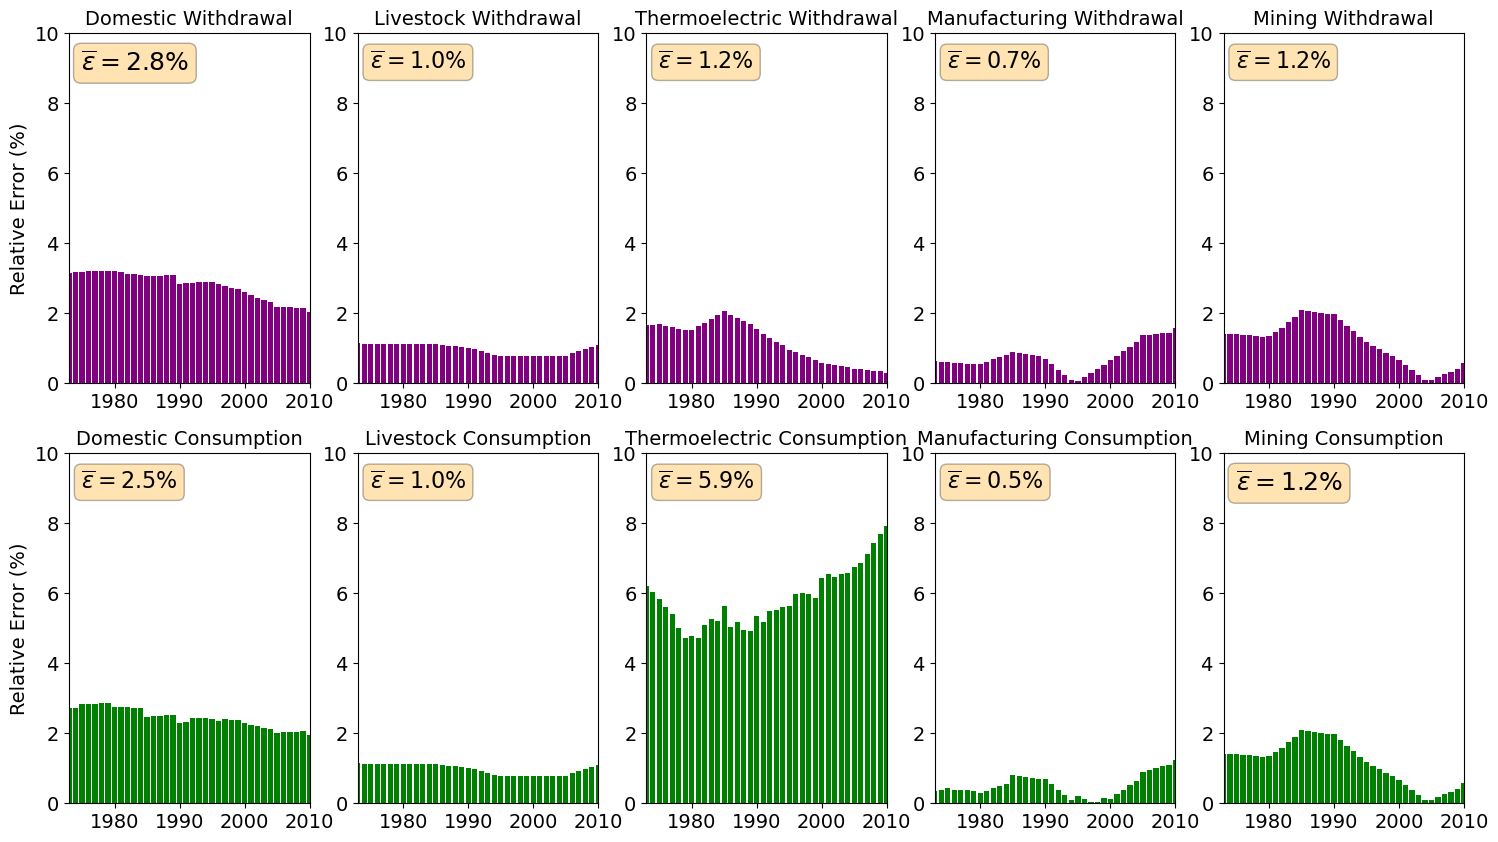

In [18]:
fig, axes = plt.subplots(figsize=(18,10), nrows=2, ncols=5)

# Generate some sample data
years = np.arange(1973, 2011)
axis_list=axes.flatten()

axis_list[0].set_xlim([1973, 2010])
axis_list[0].set_ylim([0,10])
axis_list[0].bar(years, relative_error[0, 2:], color="purple")
axis_list[0].set_title("Domestic Withdrawal", fontsize=14)
axis_list[0].set_ylabel("Relative Error (%)", fontsize=14)
axis_list[0].tick_params(axis='both', which='major', labelsize=14)
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[0]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[0].text(0.05, 0.95, textstr, transform=axis_list[0].transAxes, fontsize=18, verticalalignment='top', bbox=props)


axis_list[1].set_xlim([1973, 2010])
axis_list[1].set_ylim([0,10])
axis_list[1].bar(years, relative_error[1, 2:], color="purple")
axis_list[1].set_title("Livestock Withdrawal",  fontsize=14)
axis_list[1].tick_params(axis='both', which='major', labelsize=14)
# axis_list[1].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[1]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[1].text(0.05, 0.95, textstr, transform=axis_list[1].transAxes, fontsize=16, verticalalignment='top', bbox=props)


axis_list[2].set_xlim([1973, 2010])
axis_list[2].set_ylim([0,10])
axis_list[2].bar(years, relative_error[2, 2:], color="purple")
axis_list[2].set_title("Thermoelectric Withdrawal",  fontsize=14)
axis_list[2].tick_params(axis='both', which='major', labelsize=14)
# axis_list[2].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[2]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[2].text(0.05, 0.95, textstr, transform=axis_list[2].transAxes, fontsize=16, verticalalignment='top', bbox=props)

axis_list[3].set_xlim([1973, 2010])
axis_list[3].set_ylim([0,10])
axis_list[3].bar(years, relative_error[3, 2:], color="purple")
axis_list[3].set_title("Manufacturing Withdrawal",  fontsize=14)
axis_list[3].tick_params(axis='both', which='major', labelsize=14)
# axis_list[3].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[3]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[3].text(0.05, 0.95, textstr, transform=axis_list[3].transAxes, fontsize=16, verticalalignment='top', bbox=props)

axis_list[4].set_xlim([1973, 2010])
axis_list[4].set_ylim([0,10])
axis_list[4].bar(years, relative_error[4, 2:], color="purple")
axis_list[4].set_title("Mining Withdrawal",  fontsize=14)
axis_list[4].tick_params(axis='both', which='major', labelsize=14)
# axis_list[4].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[4]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[4].text(0.05, 0.95, textstr, transform=axis_list[4].transAxes, fontsize=16, verticalalignment='top', bbox=props)

# Consumption part
axis_list[5].set_xlim([1973, 2010])
axis_list[5].set_ylim([0,10])
axis_list[5].bar(years, relative_error[5, 2:], color="green")
axis_list[5].set_title("Domestic Consumption",  fontsize=14)
axis_list[5].tick_params(axis='both', which='major', labelsize=14)
# axis_list[5].set_xlabel("Year")
axis_list[5].set_ylabel("Relative Error (%)", fontsize=14)
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[5]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[5].text(0.05, 0.95, textstr, transform=axis_list[5].transAxes, fontsize=16, verticalalignment='top', bbox=props)

axis_list[6].set_xlim([1973, 2010])
axis_list[6].set_ylim([0,10])
axis_list[6].bar(years, relative_error[6, 2:], color="green")
axis_list[6].set_title("Livestock Consumption", fontsize=14)
axis_list[6].tick_params(axis='both', which='major', labelsize=14)
# axis_list[6].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[6]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[6].text(0.05, 0.95, textstr, transform=axis_list[6].transAxes, fontsize=16, verticalalignment='top', bbox=props)


axis_list[7].set_xlim([1973, 2010])
axis_list[7].set_ylim([0,10])
axis_list[7].bar(years, relative_error[7, 2:], color="green")
axis_list[7].set_title("Thermoelectric Consumption",  fontsize=14)
axis_list[7].tick_params(axis='both', which='major', labelsize=14)
# axis_list[7].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[7]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[7].text(0.05, 0.95, textstr, transform=axis_list[7].transAxes, fontsize=16, verticalalignment='top', bbox=props)

axis_list[8].set_xlim([1973, 2010])
axis_list[8].set_ylim([0,10])
axis_list[8].bar(years, relative_error[8, 2:], color="green")
axis_list[8].set_title("Manufacturing Consumption",  fontsize=14)
axis_list[8].tick_params(axis='both', which='major', labelsize=14)
# axis_list[8].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[8]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[8].text(0.05, 0.95, textstr, transform=axis_list[8].transAxes, fontsize=16, verticalalignment='top', bbox=props)

axis_list[9].set_xlim([1973, 2010])
axis_list[9].set_ylim([0,10])
axis_list[9].bar(years, relative_error[9, 2:], color="green")
axis_list[9].set_title("Mining Consumption",  fontsize=14)
axis_list[9].tick_params(axis='both', which='major', labelsize=14)
# axis_list[9].set_xlabel("Year")
# Add the text box
textstr = r'$\overline{\epsilon} = $' + str(np.round(np.nanmean(relative_error[9]),1)) + "%"
props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
axis_list[9].text(0.05, 0.95, textstr, transform=axis_list[9].transAxes, fontsize=18, verticalalignment='top', bbox=props)

plt.savefig("Results/png_format/Remapping_robustness_relative_error.png", format='png', edgecolor='none', dpi=600)
# Display the plot
plt.show()

